# Group 5: Movie Recommender Challenge: Unsupervised Learning - EDSA

### Euphrasia Notebook 

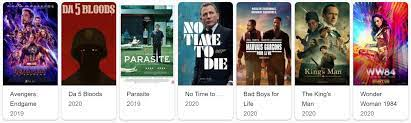

## 1. Challenge Description

In today’s technology driven world, recommender systems are socially and economically critical for ensuring that individuals can make appropriate choices surrounding the content they engage with on a daily basis. One application where this is especially true surrounds movie content recommendations; where intelligent algorithms can help viewers find great titles from tens of thousands of options.

With this context, EDSA is challenging US to construct a recommendation algorithm based on content or collaborative filtering, capable of accurately predicting how a user will rate a movie they have not yet viewed based on their historical preferences.

Providing an accurate and robust solution to this challenge has immense economic potential, with users of the system being exposed to content they would like to view or purchase - generating revenue and platform affinity.

## 2. Evaluation Metric

The evaluation metric for this competition is Root Mean Square Error. Root Mean Square Error (RMSE) is commonly used in regression analysis and forecasting, and measures the standard deviation of the residuals arising between predicted and actual observed values for a modelling process. For our task of generating user movie ratings via recommendation algorithms, the the formula is given by:

![RMSE.PNG](resources/imgs/RMSE.png)


Where R is the total number of recommendations generated for users and movies, with r_{ui} and r-hat_{ui} being the true, and predicted ratings for user u watching movie i, respectively.

## 3. Importing Libraries

Import supporting python libraries to help construct our recommendation model.

In [77]:
# Data manipulation
import numpy as np 
import pandas as pd   
import re

# Ignore warnings 
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Data visualization
import matplotlib
import seaborn as sns 
import matplotlib.pyplot as plt 
from wordcloud import WordCloud, STOPWORDS 

# Style
import matplotlib.style as style 
sns.set(font_scale=1.5)
style.use('seaborn-pastel')
sns.set(style="whitegrid")
sns.set_style("dark")

# Building recommender systems
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise import SVD
from surprise import KNNWithMeans
from surprise.model_selection import cross_validate
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

## 4. Importing Data

In [78]:
import os
os.chdir('C:/Users/Drikus/OneDrive/Documents/EXPLORE Coursework/Unsupervised/PredictData')

In [79]:
movies = pd.read_csv('movies.csv')
imdb_data = pd.read_csv('imdb_data.csv')
tags = pd.read_csv('tags.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## 5. Viewing data

In [80]:
# Display the first 5 entries in each dataframe 
display(movies.head())
display(imdb_data.head())
display(tags.head())
display(train.head())

# Count the number of unique entries for features of interest
unique_movies = len(movies['movieId'].unique().tolist())
unique_tags = len(tags['tag'].unique().tolist())
unique_users = len(train['userId'].unique().tolist())
unique_directors = len(imdb_data['director'].unique().tolist())
unique_actors = len(imdb_data['title_cast'].unique().tolist())

# Create a dataframe to store the number of unique entries for features of interest
unique = pd.DataFrame({"movies": [unique_movies],
                       "tags" : [unique_tags],
                       "users": [unique_users],
                       "directors" : [unique_directors],
                       "actors" : [unique_actors]}, index=['unique_entries'])

print('number of unique entries for features of interest')
display(unique.transpose())

# Determine and display the min and max ratings received
min_rating = train.rating.min()
max_rating = train.rating.max()
print('Lowest rating: {}'.format(min_rating))
print('Highest rating: {}'.format(max_rating))

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


number of unique entries for features of interest


,unique_entries
movies,62423
tags,73051
users,162541
directors,11787
actors,17144


Lowest rating: 0.5
Highest rating: 5.0


## 6. Data Engineering for visualization

In [81]:
#feature selection and creating a new dataframe
df = imdb_data[['movieId','title_cast','director', 'plot_keywords']]
df = df.merge(movies[['movieId', 'genres', 'title']], on='movieId', how='inner')
df.head()

,movieId,title_cast,director,plot_keywords,genres,title
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,toy|rivalry|cowboy|cgi animation,Adventure|Animation|Children|Comedy|Fantasy,Toy Story (1995)
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,board game|adventurer|fight|game,Adventure|Children|Fantasy,Jumanji (1995)
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,boat|lake|neighbor|rivalry,Comedy|Romance,Grumpier Old Men (1995)
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,black american|husband wife relationship|betra...,Comedy|Drama|Romance,Waiting to Exhale (1995)
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,fatherhood|doberman|dog|mansion,Comedy,Father of the Bride Part II (1995)


#### Convert datatypes,remove spacing and pipes between words and limit the number of keywords

In [82]:
# Convert data types to strings for string handling
df['title_cast'] = df.title_cast.astype(str)
df['plot_keywords'] = df.plot_keywords.astype(str)
df['genres'] = df.genres.astype(str)
df['director'] = df.director.astype(str)

# Removing spaces between names
df['director'] = df['director'].apply(lambda x: "".join(x.lower() for x in x.split()))
df['title_cast'] = df['title_cast'].apply(lambda x: "".join(x.lower() for x in x.split()))

# Discarding the pipes between the actors' full names and getting only the first three names
df['title_cast'] = df['title_cast'].map(lambda x: x.split('|')[:3])
df['title_cast'] = df['title_cast'].apply(lambda x: " ".join(x))

# Discarding the pipes between the plot keywords' and getting only the first five words
df['plot_keywords'] = df['plot_keywords'].map(lambda x: x.split('|')[:5])
df['plot_keywords'] = df['plot_keywords'].apply(lambda x: " ".join(x))

# Discarding the pipes between the genres 
df['genres'] = df['genres'].map(lambda x: x.lower().split('|'))
df['genres'] = df['genres'].apply(lambda x: " ".join(x))

df.head()

,movieId,title_cast,director,plot_keywords,genres,title
0,1,tomhanks timallen donrickles,johnlasseter,toy rivalry cowboy cgi animation,adventure animation children comedy fantasy,Toy Story (1995)
1,2,robinwilliams jonathanhyde kirstendunst,jonathanhensleigh,board game adventurer fight game,adventure children fantasy,Jumanji (1995)
2,3,waltermatthau jacklemmon sophialoren,markstevenjohnson,boat lake neighbor rivalry,comedy romance,Grumpier Old Men (1995)
3,4,whitneyhouston angelabassett lorettadevine,terrymcmillan,black american husband wife relationship betra...,comedy drama romance,Waiting to Exhale (1995)
4,5,stevemartin dianekeaton martinshort,alberthackett,fatherhood doberman dog mansion,comedy,Father of the Bride Part II (1995)


## 7. Exploratory Data Analysis

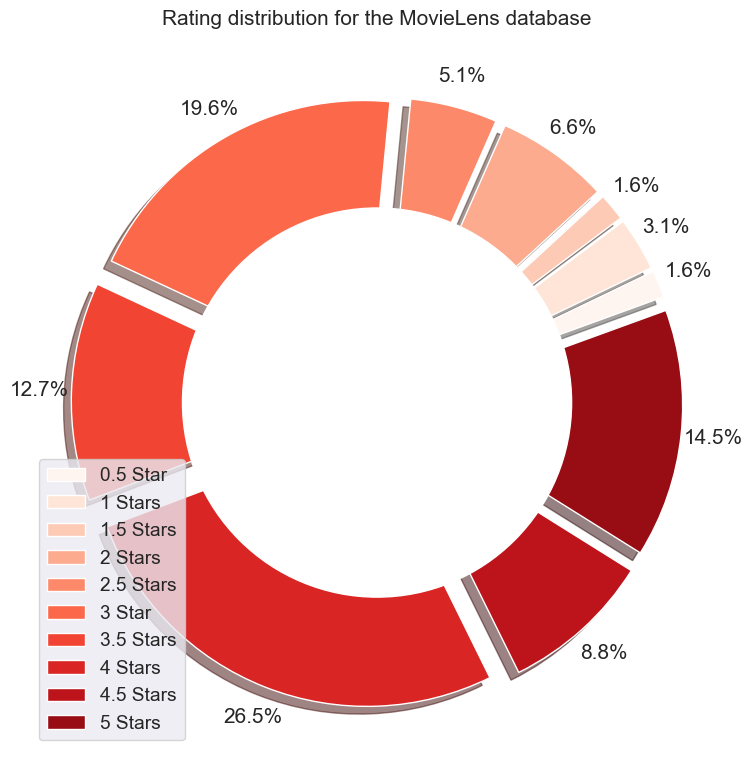

In [83]:
# Merge train with movies to join movie titles and ratings 
ratings = train.merge(movies, on='movieId', how='inner')
ratings.drop('timestamp', axis=1, inplace=True)

# Count how many ratings are in each category (1 star, 2 star, ect)
grouped = pd.DataFrame(ratings.groupby(['rating'])['title'].count())
grouped.rename(columns={'title':'rating_count'}, inplace=True)

# Creating plots 
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(122)
    
# Create colour palette
labels = ['0.5 Star', '1 Stars', '1.5 Stars', '2 Stars', '2.5 Stars', '3 Star', '3.5 Stars', '4 Stars', '4.5 Stars', '5 Stars']
theme = plt.get_cmap('Reds')
ax.set_prop_cycle("color", [theme(1. * i / len(labels))
                                 for i in range(len(labels))])
sns.set(font_scale=1.25)

# Create pie chart
pie = ax.pie(grouped['rating_count'],
                 autopct='%1.1f%%',
                 shadow=True,
                 startangle=20,
                 pctdistance=1.115,
                 explode=(0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1))
   
# Turn pie chart into a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Display donut plot with legend
plt.legend(pie[0], labels, loc="lower left")
ax.set_title('Rating distribution for the MovieLens database\n', fontsize=15)
plt.tight_layout()
plt.show()

### Distribution of averages

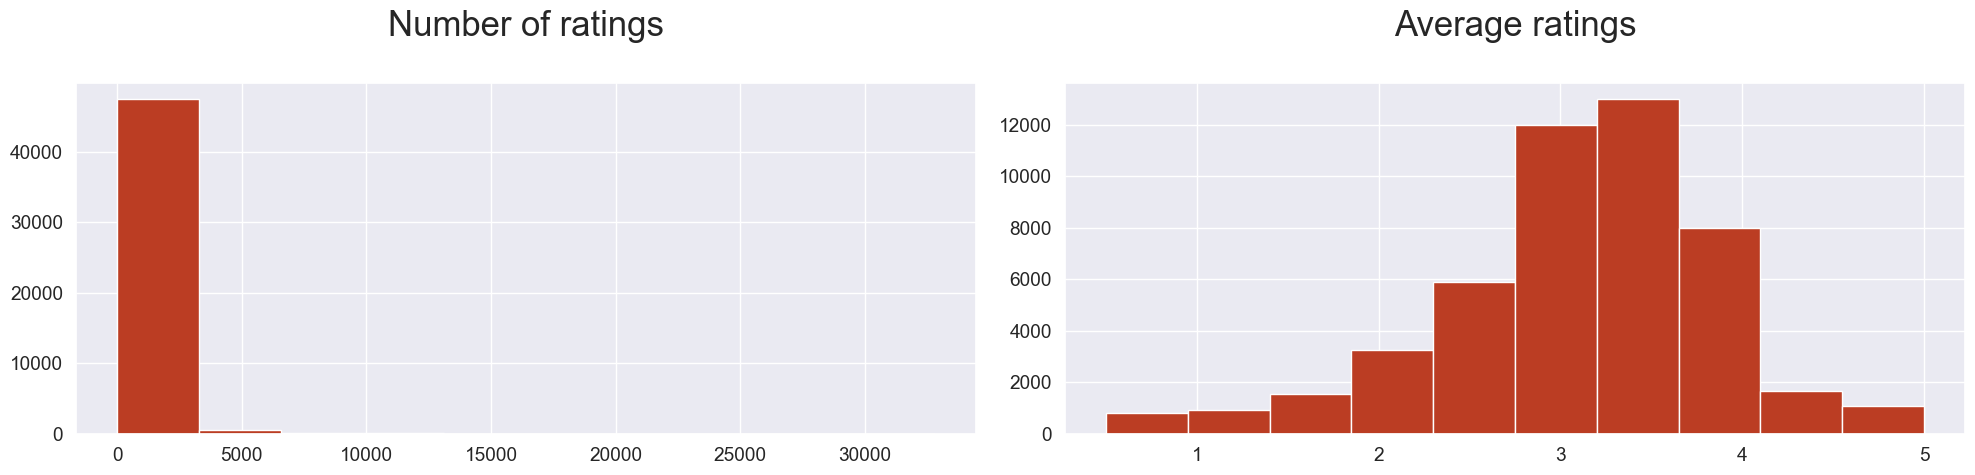

In [84]:
# Determine the average rating and number of ratings for each movie
ratings_mean_count = pd.DataFrame(ratings.groupby(['title'])[['rating']].mean())
ratings_mean_count['rating_counts'] = pd.DataFrame(ratings.groupby(['title'])['rating'].count())
ratings_mean_count['popularity'] = pd.DataFrame(ratings.groupby(['title'])['rating'].count()*ratings.groupby(['title'])['rating'].mean())

# Create a plot of the number of ratings 
f, axarr = plt.subplots(1,2, figsize=(20,5))
axarr[0].hist(ratings_mean_count['rating_counts'], bins=10, color='#bb3d23')
axarr[0].set_title('Number of ratings\n', fontsize=25)

# Create a plot showing the average ratings distribution 
axarr[1].hist(ratings_mean_count['rating'], bins=10, color='#bb3d23')
axarr[1].set_title('Average ratings\n', fontsize=25)

# Display both plots
plt.tight_layout()
plt.show()

### Plot keywords (wordclouds)

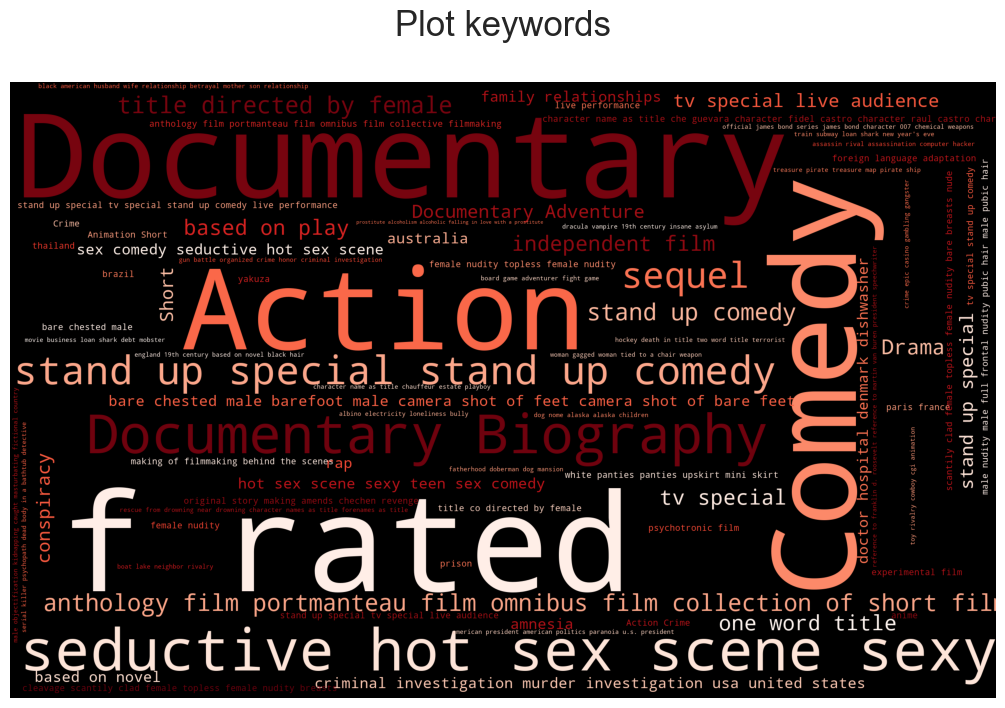

In [85]:
def wordcloud_generator(df, column):  
    """
    This function extracts all the unique keywords in a column
    and counts the number of times each keyword occurs in the column
    while ignoring words that are not meaningful.
    these keywords are then used to generate a word cloud 
    
    Input: df
           datatype: DataFrame
           column
           datatype: str
           
    Output: wordcloud
            Datatype: None
            
    """    
    keyword_counts = {}
    keyword_pair = []
    words = dict()
    
    # list of words that should be ignored
    ignore = ['nan', ' nan', 'nan ', 'seefullsummary', ' seefullsummary', 'seefullsummary ']
    
    # Extract the unique keywords 
    for keyword in [keyword for keyword in df[column] if keyword not in ignore]:
        if keyword in keyword_counts.keys():
            keyword_counts[keyword] += 1
        else:
            keyword_counts[keyword] = 1
     # Pair the keywords with their frequencies
    for word,word_freq in keyword_counts.items():
        keyword_pair.append((word,word_freq))
       
    # Sort the keywords accprding to their frequencies
    keyword_pair.sort(key = lambda x: x[1],reverse=True)
    
    # Make it wordcloud-ready
    for s in keyword_pair:
        words[s[0]] = s[1]
        
    # Create a wordcloud using the top 2000 keywords
    wordcloud = WordCloud(width=800, 
                          height=500, 
                          background_color='black', 
                          max_words=2000,
                          max_font_size=110,
                          scale=3,
                          random_state=0,
                          colormap='Reds').generate_from_frequencies(words)

    return wordcloud 

# Plot wordcloud
plot_keywords = wordcloud_generator(df, 'plot_keywords')
f = plt.figure(figsize=(20, 8)) 
plt.imshow(plot_keywords) 
plt.axis('off') 
plt.title('Plot keywords\n', fontsize=25)
plt.show()

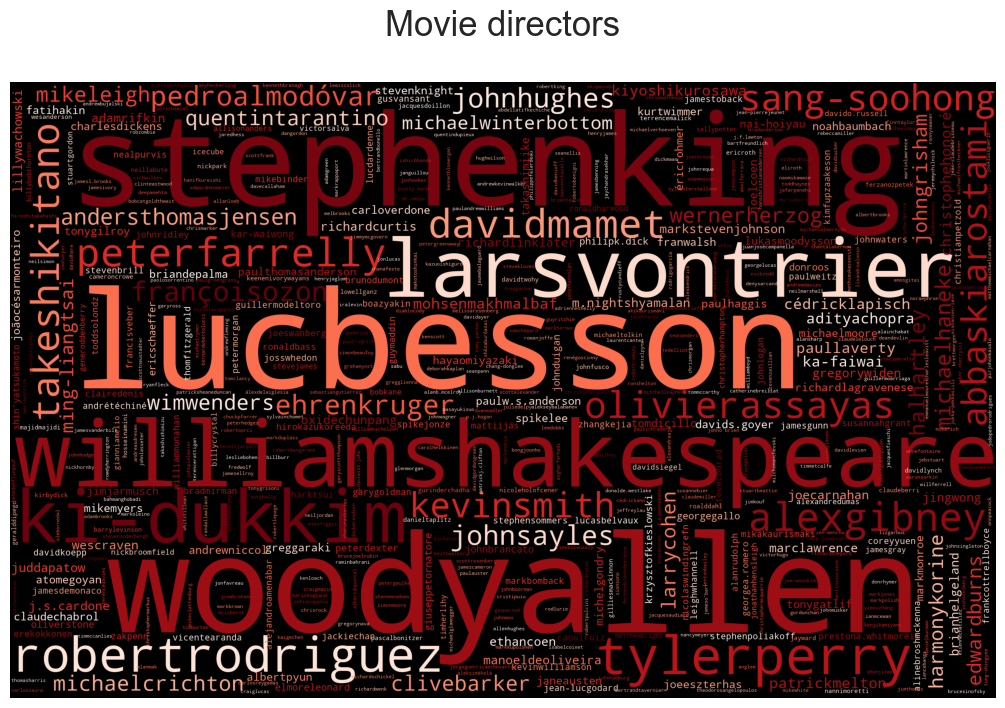

In [86]:
# Generate a WordCloud using the movie directors  
directors = wordcloud_generator(df, 'director')

# Plot the WordCloud 
f = plt.figure(figsize=(20, 8)) 
plt.imshow(directors) 
plt.axis('off') 
plt.title('Movie directors\n', fontsize=25)
plt.show()

## Memory Handling

Since we are dealing with alot of data it is necessary to free upsome space by deleting the dataframes we are not using

In [87]:

del tags
del grouped
del ratings
del ratings_mean_count

## 8. Recommendation System: Content Based Filtering

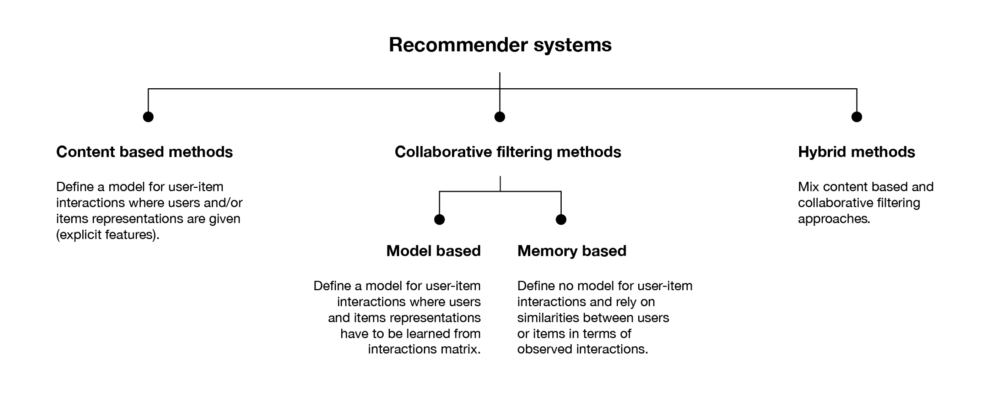

We will be using the cast, director, plot keywords and genre as the metadata for our content based recommender system. These columns will be combined to form the corpus for each film which will then be used to determine the similarity between films.

### Corpus for each film

In [88]:
# Creating an empty column and list to store the corpus for each movie
df['corpus'] = ''
corpus = []

# List of the columns we want to use to create our corpus 
columns = ['title_cast', 'director', 'plot_keywords', 'genres']

# For each movie, combine the contents of the selected columns to form it's unique corpus 
for i in range(0, len(df['movieId'])):
    words = ''
    for col in columns:
        words = words +df.iloc[i][col] + " "        
    corpus.append(words)

# Add the corpus information for each movie to the dataframe 
df['corpus'] = corpus
df.set_index('movieId', inplace=True)

# Drop the columns we don't need anymore to preserve memory
df.drop(columns=['title_cast', 'director', 'plot_keywords', 'genres'], inplace=True)

df.head()

,title,corpus
movieId,,
1,Toy Story (1995),tomhanks timallen donrickles johnlasseter toy ...
2,Jumanji (1995),robinwilliams jonathanhyde kirstendunst jonath...
3,Grumpier Old Men (1995),waltermatthau jacklemmon sophialoren marksteve...
4,Waiting to Exhale (1995),whitneyhouston angelabassett lorettadevine ter...
5,Father of the Bride Part II (1995),stevemartin dianekeaton martinshort alberthack...


In [89]:
df.size

49732

## 9. Dimensionality Reduction

#### Count Matrix

Convert corpus into a bag of words using the count vectorizer.


In [90]:
cv = CountVectorizer()
count_matrix = cv.fit_transform(df['corpus'])

## 10. Collaborative Filtering

## 11. Singular value decomposition (SVD)

In [91]:
# Evaluate the model 
svd = SVD(random_state=0)
cv = cross_validate(svd, test, cv=5, measures=['RMSE'], verbose=True)

AttributeError: 'DataFrame' object has no attribute 'raw_ratings'

## 12. Predictions

In [73]:
# Train the model on the entire dataset 
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(train[['userId','movieId','rating']], reader)
trainingSet = data.build_full_trainset()
svd.fit(trainingSet)

# Make predictions using the trained model
pred = [svd.predict(test.userId[i],test.movieId[i]).est for i in test.index]
test['rating'] = pred

## 13. Kaggle Submission

In [74]:
# Create the csv file for submission
test['Id'] = test['userId'].astype(str)+'_'+test['movieId'].astype(str)
test = test[['Id','rating']]
test.to_csv('svd_submission.csv', index=False)